# Comparing Random Walks to other analyses of time series in exchange rate modelling

## 1. First step

### 1-1. Library
- Import all library for the project

In [202]:
import os
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
import warnings
import statsmodels.api as sm

from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasRegressor
from keras.layers import LSTM, Dense
from keras.models import Sequential
from scipy.stats import probplot, kstest, chi2, anderson, kstwobign, norm
from arch.unitroot import VarianceRatio
from datetime import datetime
from keras.callbacks import EarlyStopping

### 1-2. Initialize configuration

- Simple configuration

In [9]:
## File directoty
data_dir = "./Dataset/"
res_dir = "./Results/"

## predicting time steps
n_step_pred = [1, 7, 15, 30]

## ploting layout
plt.tight_layout()
sns.set(style = 'whitegrid')
sns.despine()

<Figure size 640x480 with 0 Axes>

- Define functions

In [12]:
## Data inspection
def inspect_data(data):
    result = pd.DataFrame({'unique': data.nunique() == len(data),
                           'nunique': data.nunique(),
                           'null_count': data.isna().sum(),
                           'null_pct': round((data.isnull().sum() / len(data)) * 100, 4),
                           'dtype': data.dtypes
                          })
    
    return result


## Metric evalutaion
def Cal_ME(actual, prediction):

    actual_values = np.array(actual)
    predicted_values = np.array(prediction)
    me = np.mean(actual_values - predicted_values)
    
    return me

def Cal_RMSE(actual, prediction):
    
    rmse = np.sqrt(mean_squared_error(actual, prediction))
    
    return rmse

def Cal_RS(actual, prediction):
    
    actual_values = np.array(actual)
    predicted_values = np.array(prediction)
    r_squ = 1 - (np.sum((actual_values - predicted_values)**2) / np.sum(actual_values - np.mean(actual_values)**2))
    
    return r_squ

def Cal_MAPE(actual, prediction):
    
    actual_values = np.array(actual)
    predicted_values = np.array(prediction)
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    
    return mape


## Model evaluation
def model_evaluation(preds, test_set, model):
    eva = pd.DataFrame()
    
    for i, cur in enumerate(currency):
        hor = {}

        for n_step in n_step_pred:

            act = test_set[i].copy()
            act = act.iloc[n_step - 1:]
            ind = act.index
            act.rename(columns = {'log' : 'actual'}, inplace = True)

            # Calculate evaluation metric
            act['actual'] = np.exp(act['actual'])
            act_list = list(act['actual'])
            pred = preds[cur][n_step]
            pred = np.exp(pred)
            me = Cal_ME(act_list, pred)
            rmse = Cal_RMSE(act_list, pred)
#             rs = Cal_RS(act_list, pred)
            mape = Cal_MAPE(act_list, pred)

            # Compare the result in graph
            predict = pd.DataFrame({'predict' : pred}, index = ind)
            comp = pd.concat([act, predict], axis = 1)
            comp.plot()
            plt.title(cur + " at " + str(n_step) + "-step forecast by " + model)
            plt.savefig(res_dir + model + "_" + cur.replace('/', '') + "_" + str(n_step) + "step.png")
            plt.show()
            print("Mean Error: {:.4f}".format(me))
            print("Root Mean Squared Error: {:.4f}".format(rmse))
#             print("R Squared: {:.4f}".format(rs))
            print("Mean Absolute Percentage Error: {:.4f}".format(mape))
            hor['ME_' + str(n_step)] = me
            hor['RMSE_' + str(n_step)] = rmse
#             hor['RS_' + str(n_step)] = rs
            hor['MAPE_' + str(n_step)] = mape

        eva[cur] = hor

    eva.sort_index(ascending = True, inplace = True)
    eva.to_csv(res_dir + model +"_evaluation.csv")
        
    return eva


## 2. Exploratory data analysis (EDA)

### 2-1. Retrieve data
- In this project, we will investigate in 3 cross-exchange rates which are **USD/EUR, USD/GBP, and USD/THB**

In [27]:
currency = ["USD/EUR", "USD/GBP", "USD/THB"]
# files = ["USD_EUR Historical Data.csv", "USD_GBP Historical Data.csv", "USD_THB Historical Data.csv"] # Data from uk investing
files = ["EUR=X.csv", "GBP=X.csv", "THB=X.csv"]
curs = []
for file in files:
    cur = pd.read_csv(data_dir + file)
    curs.append(cur)


### 2-2. Data inspection

- Overall summary

In [28]:
for i, cur in enumerate(curs):
    print(f'\n Exchange rate of \033[1m{currency[i]}\033[0m')
    display(inspect_data(cur))


 Exchange rate of USD/EUR


,unique,nunique,null_count,null_pct,dtype
Date,True,5106,0,0.000,object
Open,False,4195,29,0.568,float64
High,False,4375,29,0.568,float64
Low,False,4151,29,0.568,float64
Close,False,4187,29,0.568,float64
Adj Close,False,4187,29,0.568,float64
Volume,False,1,29,0.568,float64



 Exchange rate of USD/GBP


,unique,nunique,null_count,null_pct,dtype
Date,True,5106,0,0.0000,object
Open,False,4373,17,0.3329,float64
High,False,4421,17,0.3329,float64
Low,False,4283,17,0.3329,float64
Close,False,4366,17,0.3329,float64
Adj Close,False,4366,17,0.3329,float64
Volume,False,1,17,0.3329,float64



 Exchange rate of USD/THB


,unique,nunique,null_count,null_pct,dtype
Date,True,5106,0,0.0000,object
Open,False,3578,30,0.5875,float64
High,False,3337,30,0.5875,float64
Low,False,3791,30,0.5875,float64
Close,False,3565,30,0.5875,float64
Adj Close,False,3565,30,0.5875,float64
Volume,False,1,30,0.5875,float64


- Statistics summary -  to see the range of the data and extreme values if it occurs

**Noted that:** In this project, I used only the close price of pair exchange rate to compare the performance of each model.

In [29]:
for i, cur in enumerate(ex_cur):
    print(f"Statistics summary of \033[1m{currency[i]}\033[0m")
    display(cur['Close'].describe())

Statistics summary of USD/EUR


count    5083.000000
mean        0.813499
std         0.081893
min         0.625470
25%         0.749330
50%         0.813070
75%         0.883845
max         1.042080
Name: Close, dtype: float64

Statistics summary of USD/GBP


count    5083.000000
mean        0.661514
std         0.099902
min         0.474340
25%         0.586850
50%         0.645900
75%         0.755110
max         0.932180
Name: Close, dtype: float64

Statistics summary of USD/THB


count    5083.000000
mean       33.602191
std         3.065759
min        28.070000
25%        31.299999
50%        32.817001
75%        35.079000
max        42.096001
Name: Close, dtype: float64

## 3. Data preparation

### 3-1. Data type and missing value
- Change type of 'Date' into datetime
- Assign the business days
- Replace missing values by linear interpolation

In [30]:
ex_cur = []

for cur in curs:
    
    cur['Date'] = pd.to_datetime(cur['Date'], dayfirst = True)
    start_date = pd.to_datetime('2003-12-31')
    cur = cur[cur['Date'] > start_date]
    cur = cur.set_index(['Date'], drop = True).asfreq('B')
    cur = cur.sort_index(axis = 0, ascending = True)
    cur.interpolate(method = "linear", inplace = True)
    ex_cur.append(cur)
    

### 3-2. Train-test split

- Split data into train and test, accounting for around 80:20
- Apply logarithm transformation to prevent the negative values in prediction

In [33]:
## Reserve the last 4 years for the test set (about 80:20 spliting)
spl_date_train = pd.Timestamp(year = 2019, month = 12, day = 31)
spl_date_test = spl_date_train + pd.Timedelta(days = 1)

train_set = []
log_train_set = []
test_set = []
log_test_set = []

for cur in ex_cur:
    # = Logarithm transformation = #
    cur.loc[:, 'log'] = np.log(cur['Close'])
    train = cur.loc[:spl_date_train]
    test = cur.loc[spl_date_test:]
    train_set.append(train[['Close']])
    test_set.append(test[['Close']])
    log_train_set.append(train[['log']])
    log_test_set.append(test[['log']])

### 3-3. Plotting the data

- The raw data of each pair currency in time

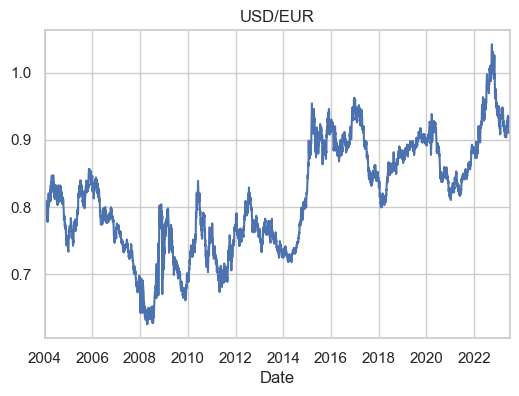

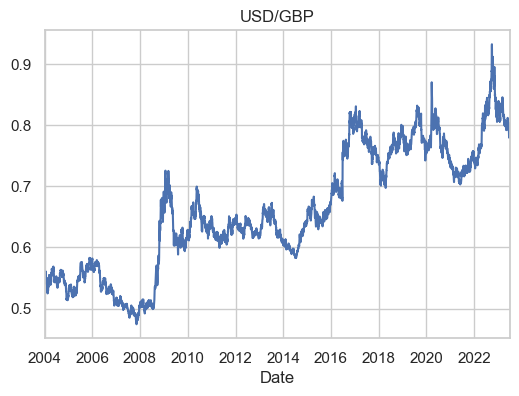

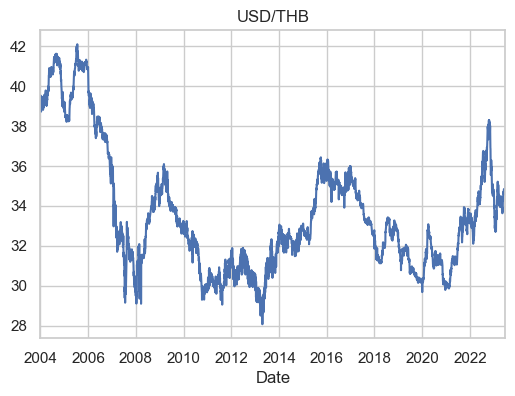

In [31]:
for i, cur in enumerate(ex_cur):
    cur['Close'].plot(kind = 'line', figsize = (6, 4))
    plt.title(currency[i])
    curr = currency[i].replace('/', '')
    plt.savefig("./Report/" + curr + "_linechart.png")
    plt.show()

- The data of each pair currency in time after above process

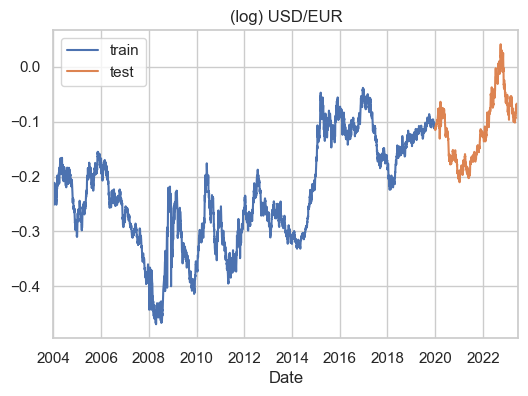

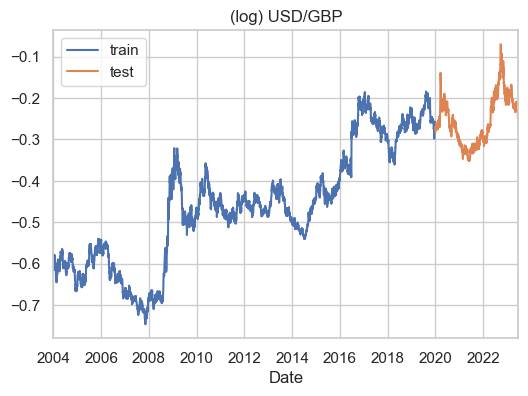

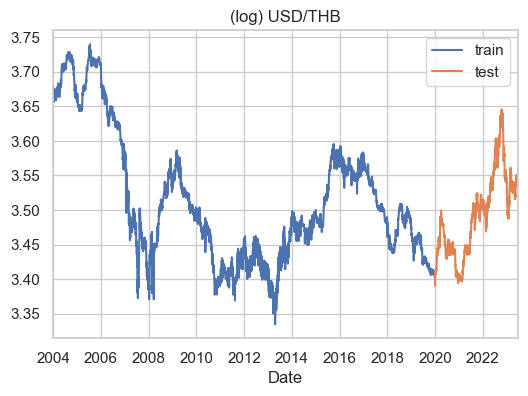

In [34]:
for i, cur in enumerate(ex_cur):
    ax = log_train_set[i].plot(kind = 'line', figsize = (6, 4))
    log_test_set[i].plot(ax = ax, kind = 'line', figsize = (6, 4))
    plt.legend(['train', 'test'])
    plt.title("(log) " + currency[i])
    curr = currency[i].replace('/', '')
    plt.savefig("./Report/" + curr + "_linechart_split.png")
    plt.show()

- Just make it for report

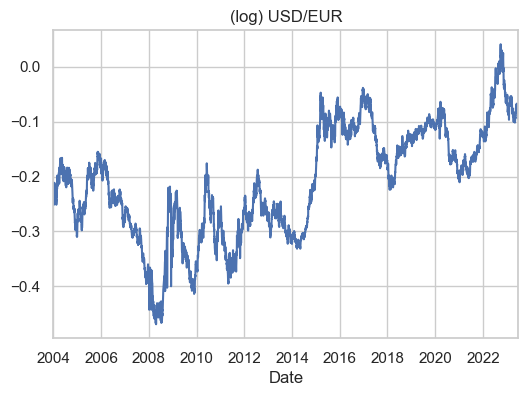

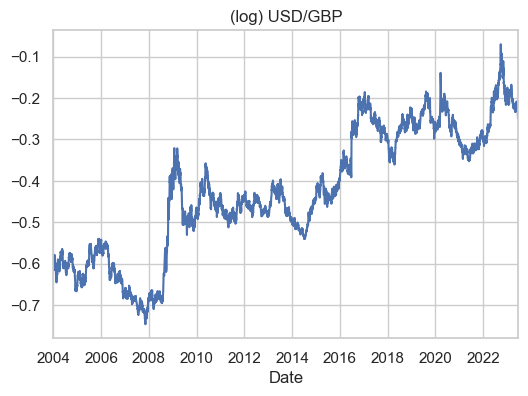

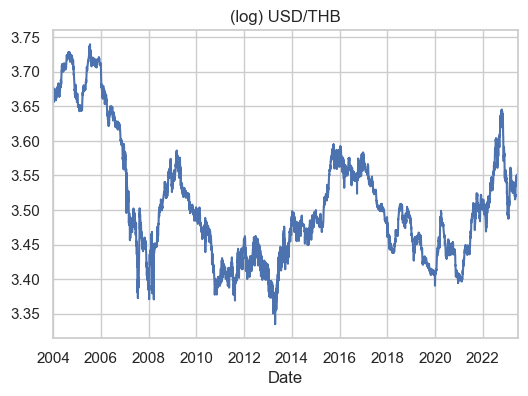

In [36]:
for i, cur in enumerate(ex_cur):
    cur['log'].plot(kind = 'line', figsize = (6, 4))
    plt.title("(log) " + currency[i])
    curr = currency[i].replace('/', '')
    plt.savefig("./Report/" + curr + "_log.png")
    plt.show()

## 4. Modelling
- In this section, there are 3 models to predict the future price of three pair exchange rate;
    1. Random Walk model
    2. ARIMA model
    3. LSTM model

### 4-1. Random Walk model

#### 4-1-1. Data set
- Define the train and test data

In [38]:
RW_train = log_train_set.copy()
RW_test = log_test_set.copy()

#### 4-1-2. Independent test
- It's crucial property for the random walk theory is an independent of the increments

###### 4-1-2-1. Lo-MacKinlay
- It is the hypothesis test for independent of the data (increments in this case)

In [44]:
for i, cur in enumerate(RW_train):
    
    lags = []
    p_val = []
    print(f'=== \033[1m{currency[i]}\033[0m ===')
    for lag in range(2, 11):
        
        data = RW_train[i].copy()
        vr = VarianceRatio(data, lags = lag)
        lags.append(lag)
        p_val.append(vr.pvalue)
    
    RWH = pd.DataFrame({'lags': lags, 'p_value': p_val})
    display(RWH)
    print('\n')
    curr = currency[i].replace('/', '')
    RWH.to_csv("./Report/" + curr +"_Lo_Mac.csv")

=== USD/EUR ===


,lags,p_value
0,2,0.052585
1,3,0.037748
2,4,0.037336
3,5,0.038894
4,6,0.039739
5,7,0.037967
6,8,0.043200
7,9,0.051672
8,10,0.055094




=== USD/GBP ===


,lags,p_value
0,2,0.470439
1,3,0.541419
2,4,0.752543
3,5,0.920727
4,6,0.851689
5,7,0.806121
6,8,0.816628
7,9,0.845423
8,10,0.820785




=== USD/THB ===


,lags,p_value
0,2,0.000000e+00
1,3,0.000000e+00
2,4,0.000000e+00
3,5,0.000000e+00
4,6,1.776357e-15
5,7,5.506706e-14
6,8,5.422329e-13
7,9,5.486278e-12
8,10,3.245848e-12


In conclusion of Lo-MacKinlay's test,
- **USD/GBP** is the only one that meet the independent hypothesis
- **USD/EUR** seems to be a partial independent of increments
- **USD/THB** rejects the independent hypothesis

###### 4-1-2-1. Pearson Chi-squared
- It is the hypothesis test for independent of the categorical data so the data will be divided into 9 groups which refers to state change of previous state (increased, decreased and stable)

In [47]:
for i, cur in enumerate(RW_train):
    print(f'=== \033[1m{currency[i]}\033[0m ===')
    # pp, pn, pz, np, nn, nz, zp, zn, zz = 0, 0, 0, 0, 0, 0, 0, 0, 0
    all_state = [0] * 9
    diff = cur['log'].diff().dropna()
    n = len(diff)
    p = (diff > 0).sum() / n
    q = (diff < 0).sum() / n
    r = (diff == 0).sum() / n
    prob = [p, q, r]
    state_1 = diff[:-1]
    state_2 = diff[1:]

    for s in range(len(state_1)):

        if state_1[s] > 0:
            if state_2[s] > 0:
                all_state[0] += 1
            elif state_2[s] < 0:
                all_state[1] += 1
            else:
                all_state[2] += 1

        elif state_1[s] < 0:
            if state_2[s] > 0:
                all_state[3] += 1
            elif state_2[s] < 0:
                all_state[4] += 1
            else:
                all_state[5] += 1

        else:    
            if state_2[s] > 0:
                all_state[6] += 1
            elif state_2[s] < 0:
                all_state[7] += 1
            else:
                all_state[8] += 1 

    test_stats = 0

    for x in range(len(prob)):

        for y in range(len(prob)):
            exp = (n - 1) * prob[x] * prob[y]
            test_stats += ((all_state[x * len(prob) + y] - exp) ** 2) / exp

    chi_cv5 = chi2.ppf(q = 0.95, df = 6)
    p_value = 1 - chi2.cdf(x = test_stats, df = 6)
    print("Test statistics: {0:.4f}".format(test_stats))
    print("Critical value 5: {0:.4f}".format(chi_cv5))
    print("P_value: {0:.4f}\n".format(p_value))
    

=== USD/EUR ===
Test statistics: 17.4046
Critical value 5: 12.5916
P_value: 0.0079

=== USD/GBP ===
Test statistics: 11.0864
Critical value 5: 12.5916
P_value: 0.0857

=== USD/THB ===
Test statistics: 99.9617
Critical value 5: 12.5916
P_value: 0.0000



In conclusion of Pearson Chi-squared test,
- **USD/GBP** is also the only one that cannot reject the independent hypothesis
- **USD/EUR** rejects the independent hypothesis
- **USD/THB** rejects the independent hypothesis

#### 4-1-3. Normality test
- An additional property of random walk that can make more accurate model is normally distributed of increments.

###### 4-1-3-1. All tests in one
- this step shows the visualization of the data and some test for normality as following:
    1. The plot of increments in time
    2. The histogram - expect the bell-shaped which is likely to be normalliy distributed
    3. Kolmogorov-Smirnov test - the hypothesis test for normality
    4. Anderson-Darling test - the hypothesis test for normality

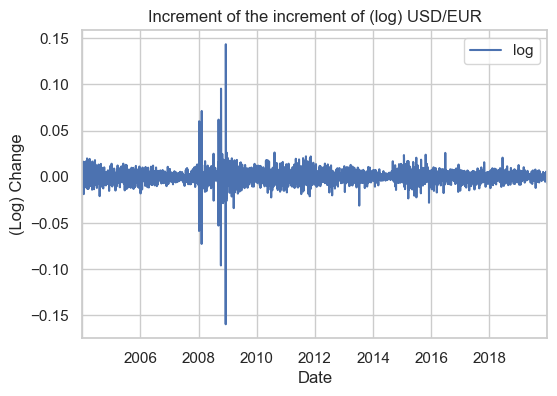

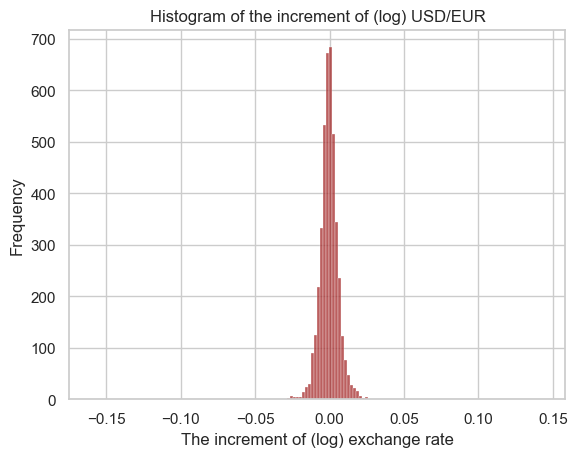

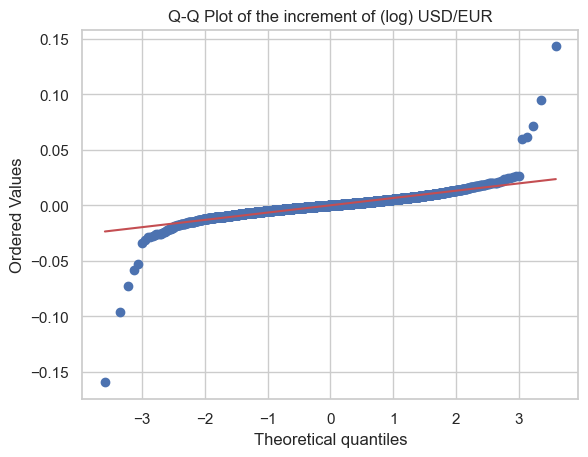

=== USD/EUR ===
= Kolmogorov-Smirnov test =
Test Statistic: 0.09125
Critical Values: 1.48021
P-value: 1.0957039796989717e-30

= Anderson-Darling test =
Test Statistic: 99.88836921709299
Critical Values: 0.786


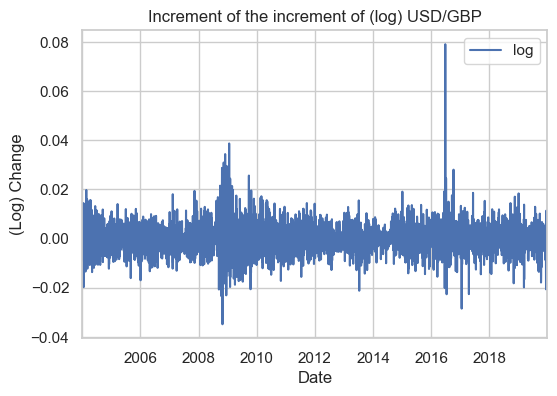

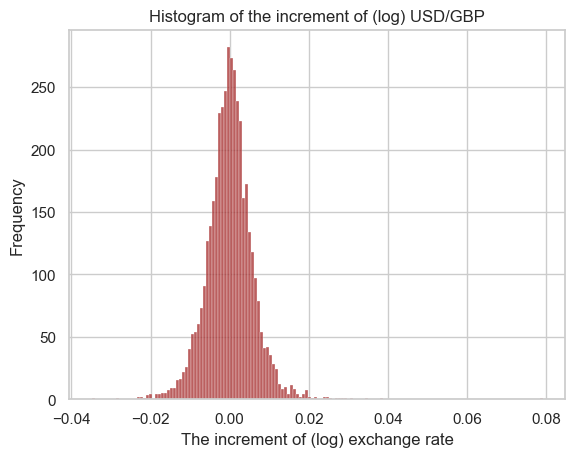

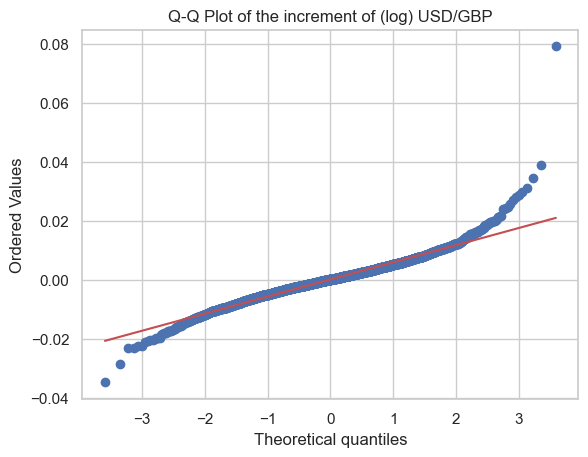

=== USD/GBP ===
= Kolmogorov-Smirnov test =
Test Statistic: 0.04811
Critical Values: 1.48021
P-value: 7.80914160122633e-09

= Anderson-Darling test =
Test Statistic: 23.1726507315434
Critical Values: 0.786


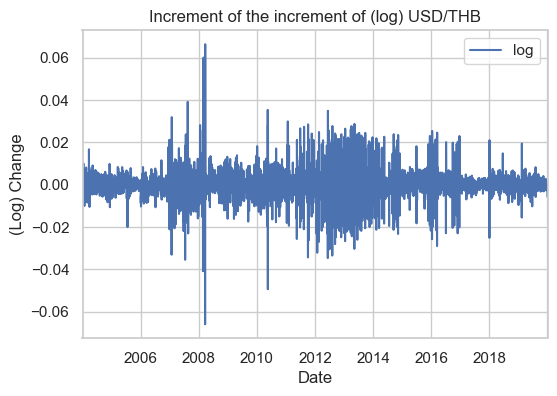

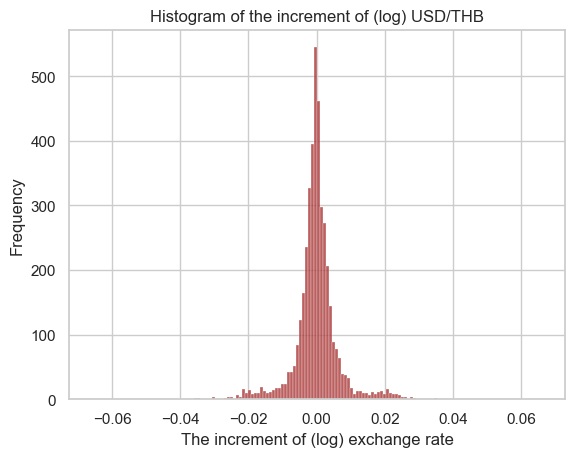

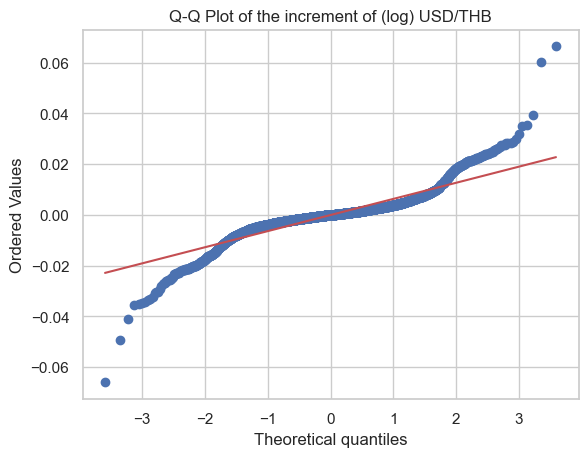

=== USD/THB ===
= Kolmogorov-Smirnov test =
Test Statistic: 0.13688
Critical Values: 1.48021
P-value: 1.1769429603313385e-68

= Anderson-Darling test =
Test Statistic: 189.9582333187509
Critical Values: 0.786


In [57]:
for i in range(len(RW_train)):
    curr = currency[i].replace('/', '')
    diff = RW_train[i].diff().dropna()
    ax = diff.plot(kind = 'line', figsize = (6, 4))
    plt.title("Increment of the increment of (log) " + currency[i])
    plt.xlabel("Date")
    plt.ylabel("(Log) Change")
    plt.savefig("./Report/" + curr + "_increments.png")
    plt.show()
    
    ## Check normality
    # Plot histogram
    sns.histplot(diff['log'], bins = 150, color = 'brown').set(title = "Histogram of " + currency[i], xlabel = 'The increments of (log) exchange rate', ylabel = 'Frequency')
    plt.title("Histogram of the increment of (log) " + currency[i])
    plt.xlabel("The increment of (log) exchange rate")
    plt.ylabel("Frequency")
    plt.savefig("./Report/" + curr + "_hist.png")
    plt.show()
    
    
    # Check QQ-Plot
    probplot(diff['log'], dist = "norm", plot = plt)
    plt.title("Q-Q Plot of the increment of (log) " + currency[i])
    plt.savefig("./Report/" + curr + "_qqplot.png")
    plt.show()
    
    print(f'=== \033[1m{currency[i]}\033[0m ===')
    
    # reshape to standard normal distribution
    diff_reshape = (diff - diff.mean()) / diff.std()
    
    # Kolmogorov-Smirnov score
    print("= Kolmogorov-Smirnov test =")
    ks = kstest(diff_reshape['log'], cdf = "norm")
    ks_cv = kstwobign.ppf(1 - 0.05 / 2)
    print("Test Statistic: {:.5f}".format(ks[0]))
    print("Critical Values: {:.5f}".format(ks_cv))
    print("P-value: {}".format(ks[1]))
    
    # Anderson score
    result = anderson(diff_reshape['log'])
    print("\n= Anderson-Darling test =")
    print("Test Statistic:", result.statistic)
    print("Critical Values:", result.critical_values[2])
    

As the results, although the histogram plot appear to be normality, the qq-plot and two hypothesis tests clearly show that the increments of the data is not normally distributed.

#### 4-1-4. Model implementation

In [59]:
## == RW model == ##
def RW(data, n_steps = 1):
    # Estimate mean and std (var) of a jump
    diff = data.diff().dropna()
    mean = diff.mean()
    std = diff.std()
    
    # Generate the prediction
    cur_value = data.iloc[-1]['log']
    pred = cur_value + mean['log'] * n_steps
#     print(cur_value, jump, total_jump, pred)
    
    return pred


In [60]:
## == Predict the forecast at horizons == ##
RW_preds = {}
RW_start = datetime.now()

for i, cur in enumerate(currency):
    hor = {}
    
    for n_step in n_step_pred:
        hor[n_step] = []
        
        for k in range(len(RW_test[i]) - n_step + 1):
            data = pd.concat([RW_train[i], RW_test[i].iloc[:0 + k]])
            pred = RW(data, n_steps = n_step)
            hor[n_step].append(pred)
            
    RW_preds[cur] = hor

RW_stop = datetime.now()
print("RW model time: {0}".format(RW_stop - RW_start))
RW_pd = pd.DataFrame(RW_preds)
RW_pd.to_csv(res_dir + "RW_predictions.csv")
    

RW model time: 0:00:22.316234


#### 4-1-5. Prediction

In [62]:
## import saved predictions
RW_x = pd.read_csv(res_dir + "RW_predictions.csv", index_col = 0)

for cur in currency:
    RW_x[cur] = RW_x[cur].apply(ast.literal_eval)
    
RW_y = RW_x.to_dict()


#### 4-1-6. Evaluation

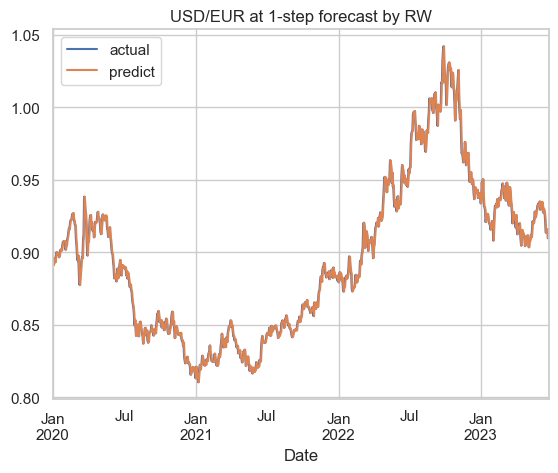

Mean Error: 0.0000
Root Mean Squared Error: 0.0046
Mean Absolute Percentage Error: 0.3721


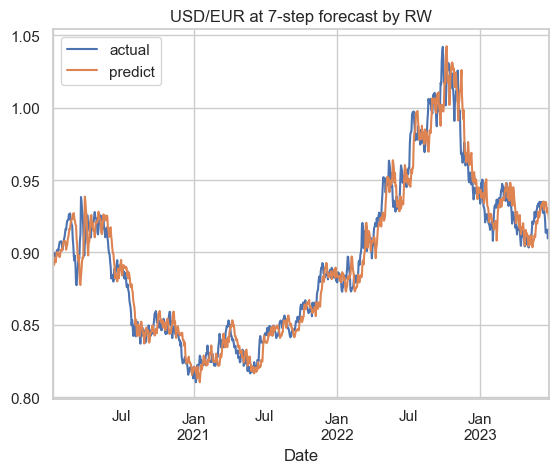

Mean Error: -0.0000
Root Mean Squared Error: 0.0121
Mean Absolute Percentage Error: 0.9730


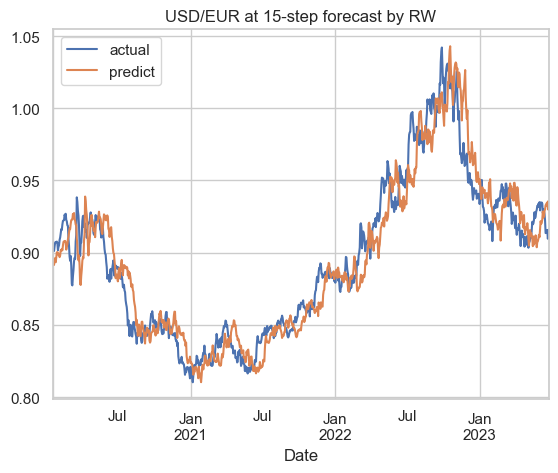

Mean Error: 0.0001
Root Mean Squared Error: 0.0169
Mean Absolute Percentage Error: 1.4742


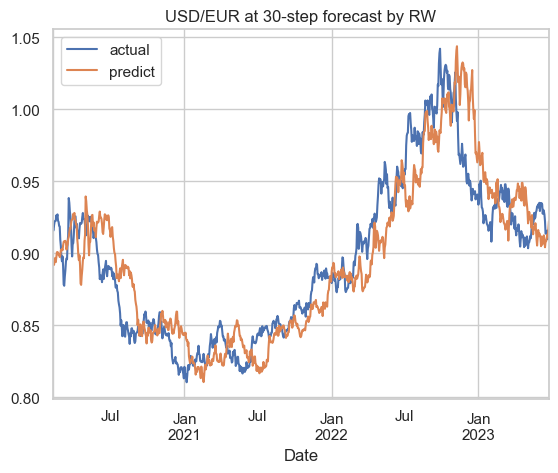

Mean Error: 0.0001
Root Mean Squared Error: 0.0242
Mean Absolute Percentage Error: 2.1152


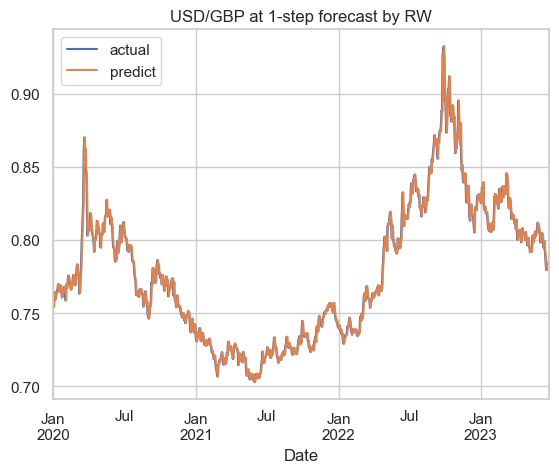

Mean Error: -0.0000
Root Mean Squared Error: 0.0052
Mean Absolute Percentage Error: 0.4544


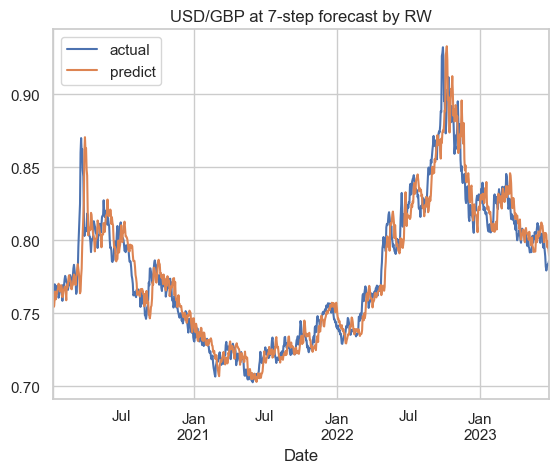

Mean Error: -0.0002
Root Mean Squared Error: 0.0140
Mean Absolute Percentage Error: 1.1882


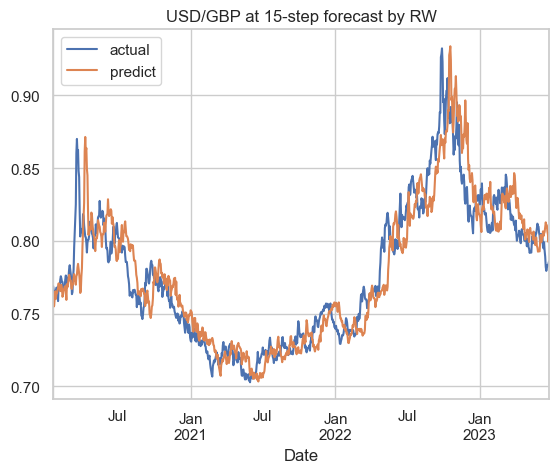

Mean Error: -0.0004
Root Mean Squared Error: 0.0189
Mean Absolute Percentage Error: 1.7669


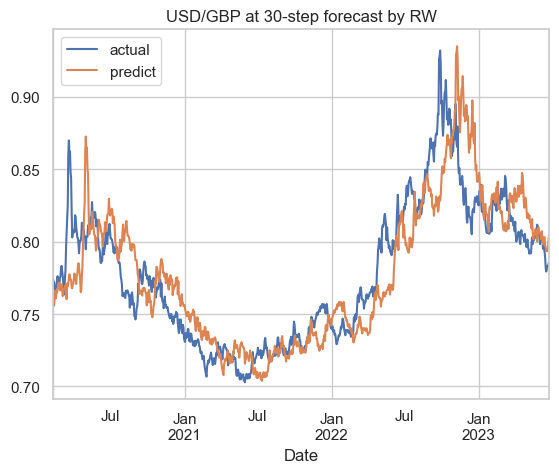

Mean Error: -0.0005
Root Mean Squared Error: 0.0254
Mean Absolute Percentage Error: 2.4068


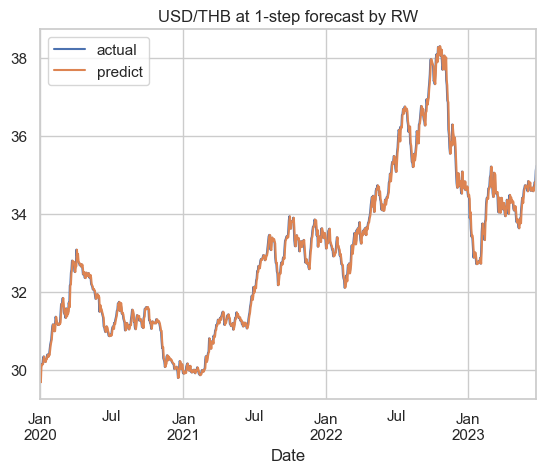

Mean Error: 0.0070
Root Mean Squared Error: 0.1479
Mean Absolute Percentage Error: 0.3253


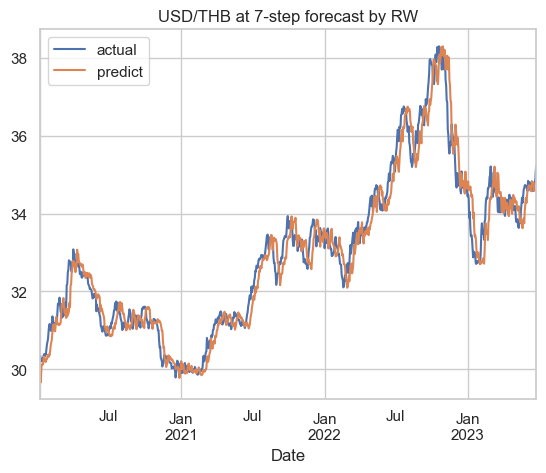

Mean Error: 0.0459
Root Mean Squared Error: 0.4453
Mean Absolute Percentage Error: 1.0177


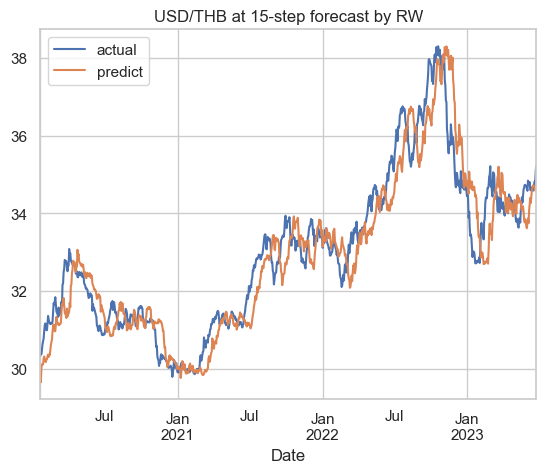

Mean Error: 0.0955
Root Mean Squared Error: 0.7108
Mean Absolute Percentage Error: 1.6461


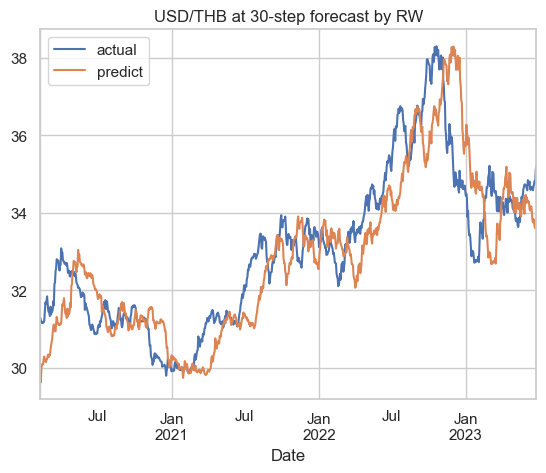

Mean Error: 0.1783
Root Mean Squared Error: 1.0503
Mean Absolute Percentage Error: 2.4298


In [63]:
## == RW evaluation == ##
RW_eva = model_evaluation(RW_y, RW_test, model = 'RW')


In [65]:
display(RW_eva)

,USD/EUR,USD/GBP,USD/THB
MAPE_1,0.372143,0.454405,0.325313
MAPE_15,1.474154,1.766852,1.646065
MAPE_30,2.115203,2.406799,2.429795
MAPE_7,0.973010,1.188192,1.017685
ME_1,0.000003,-0.000030,0.007040
ME_15,0.000086,-0.000369,0.095541
ME_30,0.000134,-0.000549,0.178282
ME_7,-0.000006,-0.000209,0.045885
RMSE_1,0.004562,0.005152,0.147936
RMSE_15,0.016901,0.018935,0.710838


### 4-2. ARIMA model

#### 4-2-1. Data set
- Define the train and test data

In [73]:
ARIMA_train = log_train_set.copy()
ARIMA_test = log_test_set.copy()

#### 4-2-2. Stationary of time series data
- The only data requirement of time series model is the time series data needs to be stationary.

##### 4-2-2-1. Stationary test
- The hypothesis test for stationary is applied by ADF (non-stationary test) and KPSS (stationary test).

In [99]:
def stationary_test(data):

    # ADF Test
    adf_result = adfuller(data)
    adf_stats = adf_result[0]
    adf_p_value = adf_result[1]
    adf_CV_5 = adf_result[4]['5%']
    print(f'=== \033[1m{currency[i]}\033[0m ===')
    print("ADF Test:")
    print(f'Critical Value (5%): {adf_CV_5:.4f}')
    print(f'Test Statistics: {adf_stats:.4f}')
    print(f'p-value: {adf_p_value:.4f}\n')

    # KPSS Test
    kpss_result = kpss(data, regression = "c", nlags = "auto")
    kpss_stats = kpss_result[0]
    kpss_p_value = kpss_result[1]
    kpss_CV_5 = kpss_result[3]['5%']
    print("KPSS Test:")
    print(f'Critical Value (5%): {kpss_CV_5:.4f}')
    print(f'Test Statistics: {kpss_stats:.4f}')
    print(f'p-value: {kpss_p_value:.4f}\n')
    

In [100]:
for cur in ARIMA_train:
    stationary_test(cur)

=== USD/THB ===
ADF Test:
Critical Value (5%): -2.8622
Test Statistics: -1.8181
p-value: 0.3715

KPSS Test:
Critical Value (5%): 0.4630
Test Statistics: 4.3460
p-value: 0.0100



/Users/dk/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


=== USD/THB ===
ADF Test:
Critical Value (5%): -2.8622
Test Statistics: -1.1575
p-value: 0.6916

KPSS Test:
Critical Value (5%): 0.4630
Test Statistics: 7.8427
p-value: 0.0100



/Users/dk/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


=== USD/THB ===
ADF Test:
Critical Value (5%): -2.8622
Test Statistics: -1.6068
p-value: 0.4802

KPSS Test:
Critical Value (5%): 0.4630
Test Statistics: 3.5050
p-value: 0.0100



/Users/dk/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


#### 4-2-2. Trend and Seasonal Decomposition with Loess (STL)
- It's used to decompose some time series components like trend and seasonal. In this project, STL is used to make an evidence that we don't need the SARIMA model because the seanonlity component barely affects to the raw data.

In [105]:
def STL_decomp(t, data, print_out = 0):
    
    stl = STL(data, seasonal = seasonal, period = period)
    res = stl.fit()

    # Plot the graph only for checking
    if print_out:
        fig = res.plot()
        curr = currency[t].replace('/', '')
        plt.savefig("./Report/" + curr + "_STL.png")
        plt.show()
        
        stationary_test(res.resid)
        
    return res.resid


In [102]:
## Check the business day in a year (2004)
days = 0

while AR_train[0].index[0].year == AR_train[0].index[days].year: 
    days += 1
    
print(f"No. day in a year (2004): {days} days")

No. day in a year (2004): 262 days


- Detrend data

In [103]:
seasonal = 17
period = days

for i in range(3):
    
    stl = STL(AR_train[i], seasonal = seasonal, period = period)
    res = stl.fit()

    x = pd.DataFrame(res.trend)
    x.rename(columns= {'trend': 'log'}, inplace=True)
    y = AR_train[i] - x
    stationary_test(y)


=== USD/EUR ===
ADF Test:
Critical Value (5%): -2.8622
Test Statistics: -6.9702
p-value: 0.0000

KPSS Test:
Critical Value (5%): 0.4630
Test Statistics: 0.0265
p-value: 0.1000



/Users/dk/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


=== USD/GBP ===
ADF Test:
Critical Value (5%): -2.8622
Test Statistics: -6.6746
p-value: 0.0000

KPSS Test:
Critical Value (5%): 0.4630
Test Statistics: 0.0311
p-value: 0.1000



/Users/dk/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


=== USD/THB ===
ADF Test:
Critical Value (5%): -2.8622
Test Statistics: -7.0591
p-value: 0.0000

KPSS Test:
Critical Value (5%): 0.4630
Test Statistics: 0.0583
p-value: 0.1000



/Users/dk/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


- All STL processes

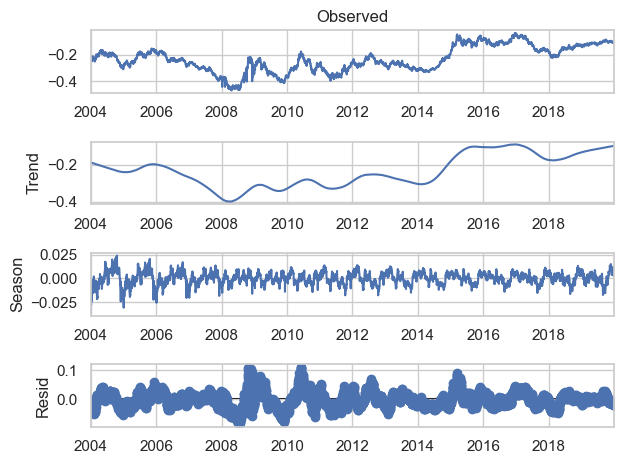

=== USD/THB ===
ADF Test:
Critical Value (5%): -2.8622
Test Statistics: -6.4605
p-value: 0.0000

KPSS Test:
Critical Value (5%): 0.4630
Test Statistics: 0.0255
p-value: 0.1000



/Users/dk/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


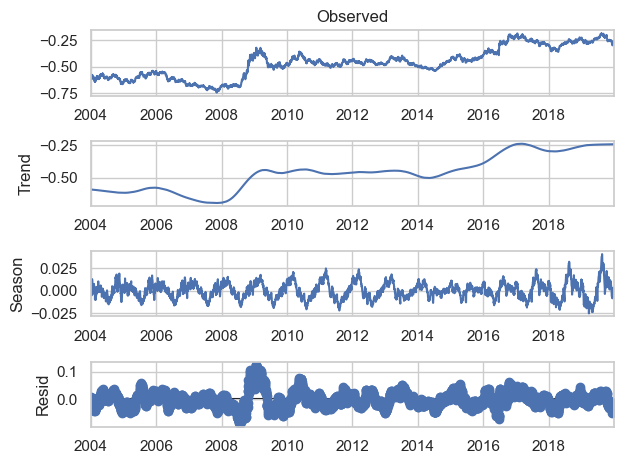

=== USD/THB ===
ADF Test:
Critical Value (5%): -2.8622
Test Statistics: -5.9046
p-value: 0.0000

KPSS Test:
Critical Value (5%): 0.4630
Test Statistics: 0.0290
p-value: 0.1000



/Users/dk/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


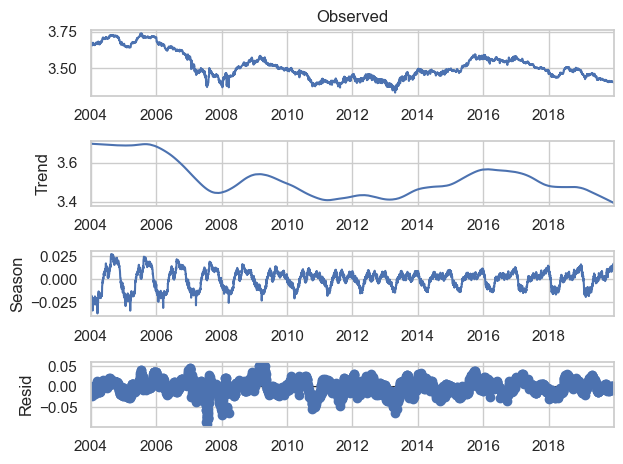

=== USD/THB ===
ADF Test:
Critical Value (5%): -2.8622
Test Statistics: -7.0596
p-value: 0.0000

KPSS Test:
Critical Value (5%): 0.4630
Test Statistics: 0.0457
p-value: 0.1000



/Users/dk/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [106]:
## Get the residual after substract the trend and seasonal components
# Former day count = 262 days per year
residual = []

for t, train in enumerate(AR_train): 
    STL_res = STL_decomp(t, train, print_out = 1)
    residual.append(STL_res)
    

As a result, the STL test shows that the trend is the most influent component in stationary aspect while the seasonality is hardly any effect.

#### 4-2-3. Parameters order selection
- To choose the appropriate parameters for ARIMA, the ACF and PACF plot is one of best methods to examine it.

##### 4-2-3-1. ACF and PACF plots

In [111]:
def pacf_plot_f(data, cur, words = "", print_out = 0):
    
    pacf = sm.tsa.pacf(data, nlags = 35)
    
    # Calculate confidence interval
    n = len(data)
    ci = norm.ppf((1+0.95)/2) / np.sqrt(n)

    # Create the ACF plot with straight-line confidence interval
    plt.figure(figsize=(8, 4))
    plt.stem(pacf, markerfmt='', linefmt='b-', basefmt='r-')
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    plt.axhline(y=ci, color='gray', linestyle='--', linewidth=1)
    plt.axhline(y=-ci, color='gray', linestyle='--', linewidth=1)
    plt.title('PACF of (log) ' + cur + " with d = 1")
    plt.xlabel('Lags')
    plt.ylabel('PACF Value')
    plt.tight_layout()
    if print_out == 1:
        curr = cur.replace('USD/', '')
        plt.savefig("./Report/PACF_" + curr + "_" + words + ".png")
    plt.show()
    
def acf_plot_f(data, cur, words = "", print_out = 0):
    
    acf = sm.tsa.acf(data, nlags = 35)
    
    # Calculate confidence interval
    n = len(data)
    ci = norm.ppf((1+0.95)/2) / np.sqrt(n)

    # Create the ACF plot with straight-line confidence interval
    plt.figure(figsize=(8, 4))
    plt.stem(acf, markerfmt='', linefmt='b-', basefmt='r-')
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    plt.axhline(y=ci, color='gray', linestyle='--', linewidth=1)
    plt.axhline(y=-ci, color='gray', linestyle='--', linewidth=1)
    plt.title('ACF of (log) ' + cur + " with d = 1")
    plt.xlabel('Lags')
    plt.ylabel('ACF Value')
    plt.tight_layout()
    if print_out == 1:
        curr = cur.replace('USD/', '')
        plt.savefig("./Report/ACF_" + curr + "_" + words + ".png")
    plt.show()
    

- The both plots and the stationary test results of first differenced data

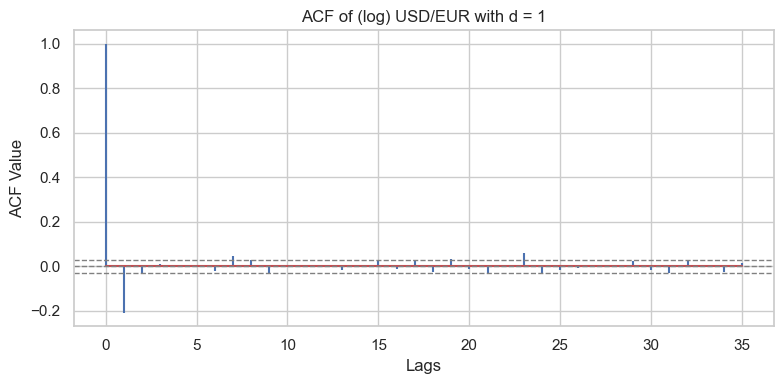

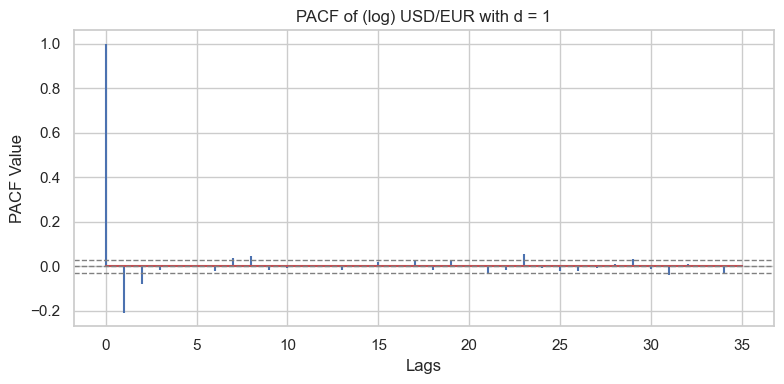

=== USD/EUR ===
Results of ADF Test:
Test Statistics: -22.337151690664978
p-value: 0.0
Critical Value (5%): -2.8622341942076295

Results of KPSS Test:
Test Statistics: 0.07316783359839085
p-value: 0.1
Critical Value (5%): 0.463



/Users/dk/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


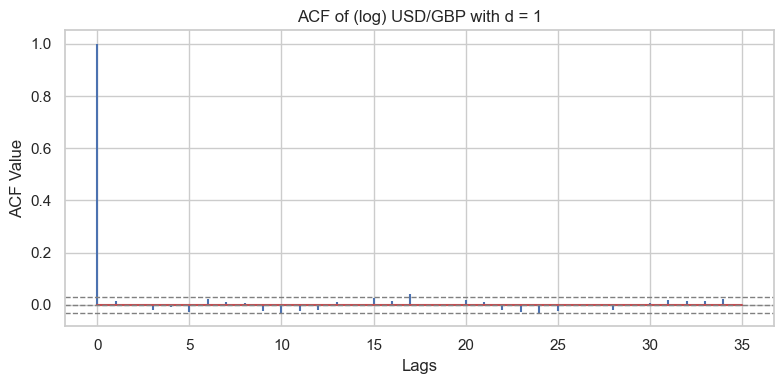

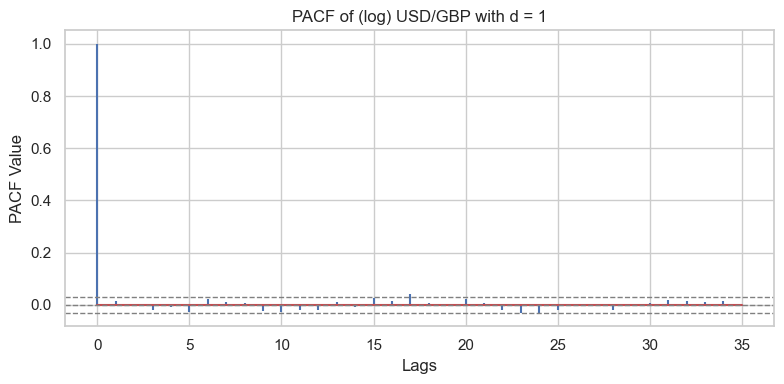

=== USD/GBP ===
Results of ADF Test:
Test Statistics: -63.526441892496706
p-value: 0.0
Critical Value (5%): -2.8622330290415605

Results of KPSS Test:
Test Statistics: 0.050481461373286754
p-value: 0.1
Critical Value (5%): 0.463



/Users/dk/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


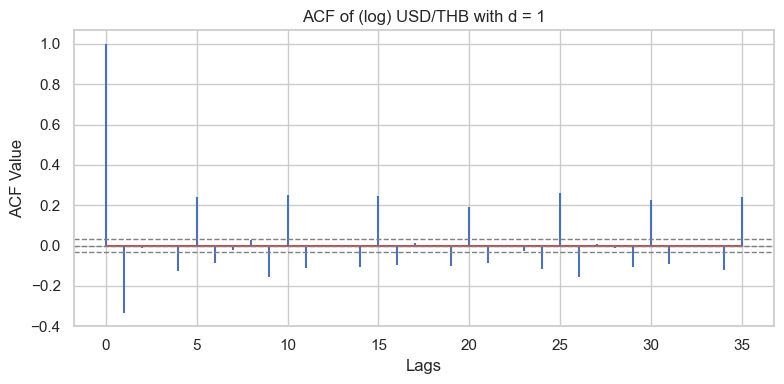

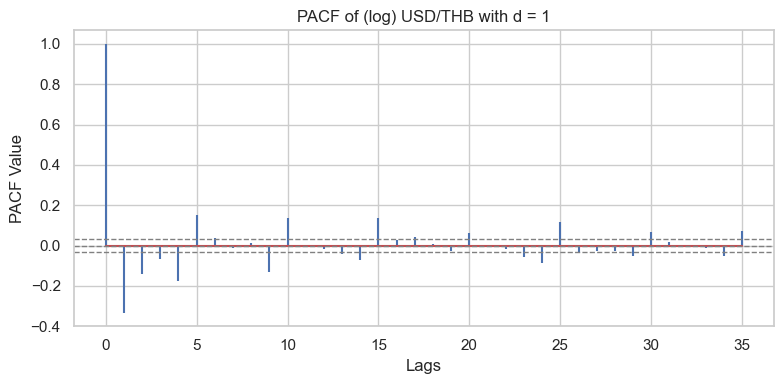

=== USD/THB ===
Results of ADF Test:
Test Statistics: -11.880489368805213
p-value: 6.194494860475625e-22
Critical Value (5%): -2.8622378818000214

Results of KPSS Test:
Test Statistics: 0.10257466544314192
p-value: 0.1
Critical Value (5%): 0.463



/Users/dk/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [112]:
for i, cur in enumerate(currency):
    res = AR_train[i].diff().dropna()
#     res = res.diff().dropna()
    
    acf_plot_f(res, cur)
    pacf_plot_f(res, cur)
    
    adf_result = adfuller(res)
    adf_stats = adf_result[0]
    adf_p_value = adf_result[1]
    adf_CV_5 = adf_result[4]['5%']
    print(f'=== {currency[i]} ===')
    print("Results of ADF Test:")
    print(f'Test Statistics: {adf_stats}')
    print(f'p-value: {adf_p_value}')
    print(f'Critical Value (5%): {adf_CV_5}\n');
    
    kpss_result = kpss(res, regression = "c", nlags = "auto")
    kpss_stats = kpss_result[0]
    kpss_p_value = kpss_result[1]
    kpss_CV_5 = kpss_result[3]['5%']
    print("Results of KPSS Test:")
    print(f'Test Statistics: {kpss_stats}')
    print(f'p-value: {kpss_p_value}')
    print(f'Critical Value (5%): {kpss_CV_5}\n')

- Select the possible parameters p,q and, r for ARIMA from PACF and ACF plot

In [113]:
## Visually possible parameters selection by ACF and PACF
arima_par = {'USD/EUR': [[0, 1, 2], [0, 1]], 'USD/GBP': [[0], [0]], 'USD/THB': [[0, 1, 4, 5], [0, 1, 2, 4, 5]]}

##### 4-2-3-2. Choose the best parameters by AIC, BIC and Breusch-Godfrey

In [180]:
warnings.simplefilter('ignore', ConvergenceWarning)
start = datetime.now()
aic_p_value = {}
bic_p_value = {}
aic = []
bic = []
d = 1
arima_eur = {'p': [], 'd': [],'q': [], 'aic': [], 'bic': [], 'autocor': []}
arima_eur = pd.DataFrame(arima_eur)
arima_gbp = {'p': [], 'd': [],'q': [], 'aic': [], 'bic': [], 'autocor': []}
arima_gbp = pd.DataFrame(arima_gbp)
arima_thb = {'p': [], 'd': [],'q': [], 'aic': [], 'bic': [], 'autocor': []}
arima_thb = pd.DataFrame(arima_thb)
min_aic = {}
min_bic = {}
min_aic_gf = {}
min_bic_gf = {}

for i, cur in enumerate(currency):
    year_aic = {}
    year_bic = {}
    year_aic_gf = {}
    year_bic_gf = {}
    
    for k in range(len(RW_test[i])):  
        data = pd.concat([AR_train[i], AR_test[i].iloc[:0 + k]])  
        
        if data.index[-1].year != data.index[-2].year:
#             diff = data.diff().dropna()
#             acf_plot_f(diff, cur)
#             pacf_plot_f(diff, cur)
            y = data.index[-1].year
            p_in = arima_par[cur][0]
            q_in = arima_par[cur][1]
            arima_year = {'p': [], 'd': [],'q': [], 'aic': [], 'bic': [], 'autocor': []}
            arima_year = pd.DataFrame(arima_year)
            
            for p in p_in:
                for q in q_in:
                    with warnings.catch_warnings():
                        warnings.filterwarnings("ignore", category=UserWarning)
                        arima_model = ARIMA(data, order = (p, d, q), enforce_stationarity = False)
                        arima_results = arima_model.fit()
                    aic = arima_results.aic
                    bic = arima_results.bic
                    
                    if arima_results.resid.isna().sum() == 0:
                        bg = acorr_breusch_godfrey(arima_results, nlags = 30)
                        new_row = pd.DataFrame({'p': p, 'd': d,'q': q, 'aic': aic, 
                                                'bic': bic, 'autocor': bg[1]}, index=[0])
                        
                        arima_year = pd.concat([arima_year, new_row], ignore_index=True)
            
            ind = arima_year['autocor'] > 0.05
            p_aic = int(arima_year[arima_year['aic'] == arima_year['aic'].min()]['p'].values)
            p_aic_gf = int(arima_year[arima_year['aic'] == arima_year[ind]['aic'].min()]['p'].values)
            q_aic = int(arima_year[arima_year['aic'] == arima_year['aic'].min()]['q'].values)
            q_aic_gf = int(arima_year[arima_year['aic'] == arima_year[ind]['aic'].min()]['q'].values)
            p_bic = int(arima_year[arima_year['bic'] == arima_year['bic'].min()]['p'].values)
            p_bic_gf = int(arima_year[arima_year['bic'] == arima_year[ind]['bic'].min()]['p'].values)
            q_bic = int(arima_year[arima_year['bic'] == arima_year['bic'].min()]['q'].values)
            q_bic_gf = int(arima_year[arima_year['bic'] == arima_year[ind]['bic'].min()]['q'].values)
            
            if i == 0:
                arima_eur = pd.concat([arima_eur, arima_year], ignore_index=True)  
                
            elif i == 1:
                arima_gbp = pd.concat([arima_gbp, arima_year], ignore_index=True)
                
            else:
                arima_thb = pd.concat([arima_thb, arima_year], ignore_index=True)
                
            year_aic[y] = [p_aic, d, q_aic]
            year_bic[y] = [p_bic, d, q_bic]
            year_aic_gf[y] = [p_aic_gf, d, q_aic_gf]
            year_bic_gf[y] = [p_bic_gf, d, q_bic_gf]
        
    min_aic[cur] = year_aic
    min_bic[cur] = year_bic
    min_aic_gf[cur] = year_aic_gf
    min_bic_gf[cur] = year_bic_gf
    

stop = datetime.now()
print("time: {0})".format(stop - start))

time: 0:03:07.211247)


- AIC scores of every year and exchange rate

In [193]:
print(f'The result of aic: ')
df = pd.DataFrame(min_aic)
display(df)
df.to_csv(res_dir + "ARIMA_aic_param.csv")


The result of aic: 


,USD/EUR,USD/GBP,USD/THB
2020,"[2, 1, 0]","[0, 1, 0]","[5, 1, 5]"
2021,"[2, 1, 0]","[0, 1, 0]","[4, 1, 5]"
2022,"[2, 1, 0]","[0, 1, 0]","[4, 1, 5]"
2023,"[1, 1, 1]","[0, 1, 0]","[4, 1, 5]"


- AIC scores of every year and exchange rate when appling Breusch-Godfrey

In [194]:
print(f'The result of aic with Breusch-Godfrey: ')
df = pd.DataFrame(min_aic_gf)
display(df)
df.to_csv(res_dir + "ARIMA_aic_gf_param.csv")


The result of aic with Breusch-Godfrey: 


,USD/EUR,USD/GBP,USD/THB
2020,"[2, 1, 0]","[0, 1, 0]","[0, 1, 5]"
2021,"[2, 1, 0]","[0, 1, 0]","[0, 1, 5]"
2022,"[1, 1, 1]","[0, 1, 0]","[0, 1, 5]"
2023,"[1, 1, 1]","[0, 1, 0]","[0, 1, 5]"


- BIC scores of every year and exchange rate

In [195]:
print(f'The result of bic: ')
df = pd.DataFrame(min_bic)
display(df)
df.to_csv(res_dir + "ARIMA_bic_param.csv")


The result of bic: 


,USD/EUR,USD/GBP,USD/THB
2020,"[0, 1, 1]","[0, 1, 0]","[5, 1, 5]"
2021,"[0, 1, 1]","[0, 1, 0]","[4, 1, 5]"
2022,"[0, 1, 1]","[0, 1, 0]","[4, 1, 5]"
2023,"[0, 1, 1]","[0, 1, 0]","[4, 1, 5]"


- BIC scores of every year and exchange rate when appling Breusch-Godfrey

In [196]:
print(f'The result of bic with Breusch-Godfrey: ')
df = pd.DataFrame(min_bic_gf)
display(df)
df.to_csv(res_dir + "ARIMA_bic_gf_param.csv")

The result of bic with Breusch-Godfrey: 


,USD/EUR,USD/GBP,USD/THB
2020,"[0, 1, 1]","[0, 1, 0]","[0, 1, 5]"
2021,"[0, 1, 1]","[0, 1, 0]","[0, 1, 5]"
2022,"[0, 1, 1]","[0, 1, 0]","[0, 1, 5]"
2023,"[1, 1, 1]","[0, 1, 0]","[0, 1, 5]"


##### 4-2-4. Model implementation with the best parameters of AIC and Breusch-Godfrey

In [198]:
## == Predict the forecast at horizons == ##
ARIMA_preds = {}
ARIMA_start = datetime.now()

for i, cur in enumerate(currency):
    hor = {}
    p_year = {}
    
    for n_step in n_step_pred:
        hor[n_step] = []
        print("=== {0} in {1}-step ===".format(cur, n_step))
        start = datetime.now()
        
        for k in range(len(ARIMA_test[i]) - n_step + 1):
            data = pd.concat([ARIMA_train[i], ARIMA_test[i].iloc[:0 + k]])
            y = data.index[-1].year
            if y == 2019:
                y += 1
            p, d, q = min_aic_gf[cur][y]
                
            model = ARIMA(endog = data, order=(p,d,q))
            model_fit = model.fit()
            pred = model_fit.forecast(steps = n_step)[-1]
            hor[n_step].append(pred)
            
            if data.index[-1].year != data.index[-2].year:
                stop = datetime.now()
                print("{0} is done ... (time: {1})".format(y - 1, stop - start))
                start = datetime.now()
        
        stop = datetime.now()
        print("{0} is done ... (time: {1})".format(y, stop - start))
            
    ARIMA_preds[cur] = hor
    
ARIMA_stop = datetime.now()
print("ARIMA model time: {0}".format(ARIMA_stop - ARIMA_start))

## Save AR_predictions
ARIMA_pd = pd.DataFrame(ARIMA_preds)
ARIMA_pd.to_csv(res_dir + "ARIMA_predictions.csv")


=== USD/EUR in 1-step ===
2019 is done ... (time: 0:00:01.307073)
2020 is done ... (time: 0:02:02.682430)
2021 is done ... (time: 0:02:18.785884)
2022 is done ... (time: 0:04:55.053040)
2023 is done ... (time: 0:02:26.714183)
=== USD/EUR in 7-step ===
2019 is done ... (time: 0:00:01.216288)
2020 is done ... (time: 0:01:58.941874)
2021 is done ... (time: 0:02:19.734420)
2022 is done ... (time: 0:04:49.706030)
2023 is done ... (time: 0:02:12.974095)
=== USD/EUR in 15-step ===
2019 is done ... (time: 0:00:01.210845)
2020 is done ... (time: 0:01:56.096940)
2021 is done ... (time: 0:02:12.274074)
2022 is done ... (time: 0:04:44.414170)
2023 is done ... (time: 0:02:04.204207)
=== USD/EUR in 30-step ===
2019 is done ... (time: 0:00:01.262159)
2020 is done ... (time: 0:01:56.078388)
2021 is done ... (time: 0:02:12.958299)
2022 is done ... (time: 0:04:44.771173)
2023 is done ... (time: 0:01:48.103573)
=== USD/GBP in 1-step ===
2019 is done ... (time: 0:00:00.628228)
2020 is done ... (time: 0:01

##### 4-2-5. Evaluation

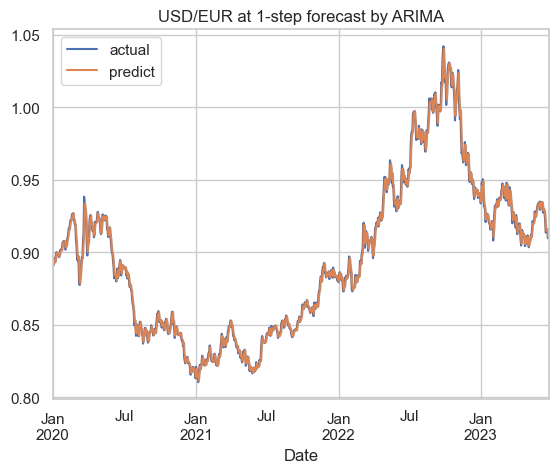

Mean Error: 0.0000
Root Mean Squared Error: 0.0047
Mean Absolute Percentage Error: 0.3845


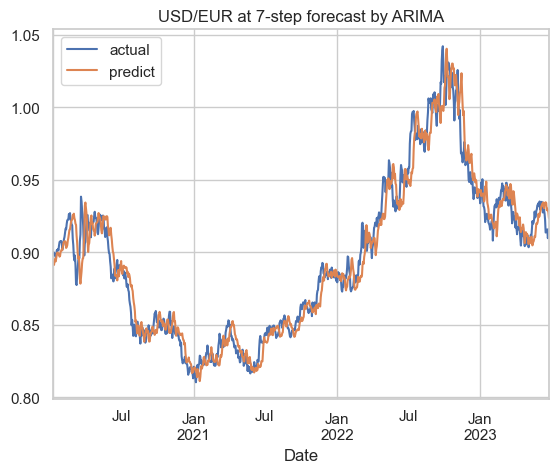

Mean Error: 0.0002
Root Mean Squared Error: 0.0121
Mean Absolute Percentage Error: 0.9724


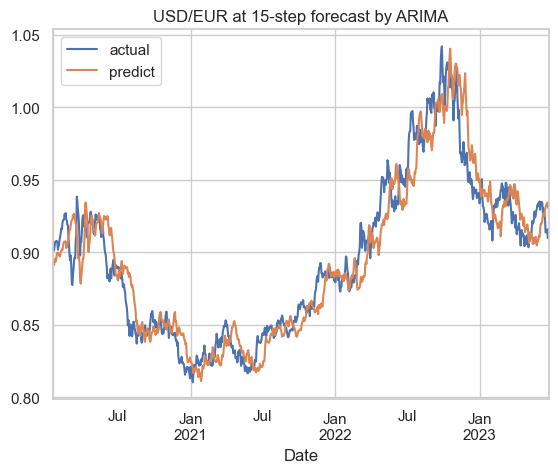

Mean Error: 0.0005
Root Mean Squared Error: 0.0169
Mean Absolute Percentage Error: 1.4751


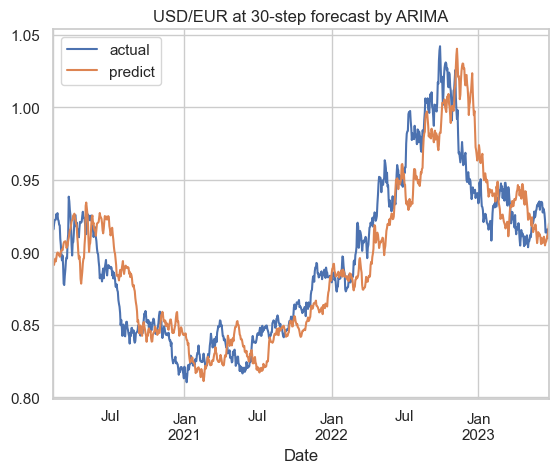

Mean Error: 0.0008
Root Mean Squared Error: 0.0242
Mean Absolute Percentage Error: 2.1243


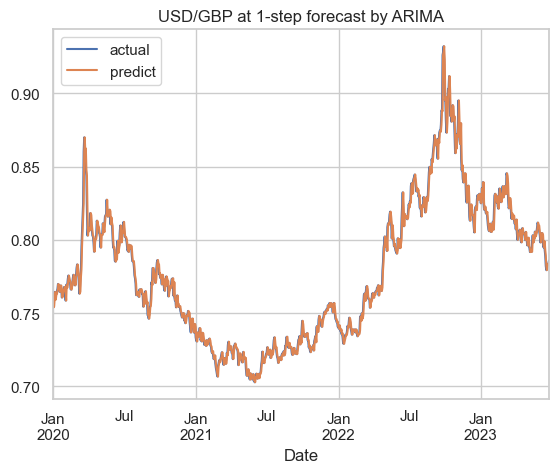

Mean Error: 0.0000
Root Mean Squared Error: 0.0052
Mean Absolute Percentage Error: 0.4542


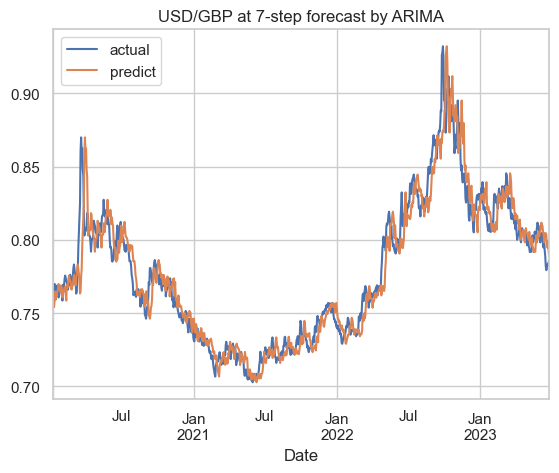

Mean Error: 0.0002
Root Mean Squared Error: 0.0139
Mean Absolute Percentage Error: 1.1838


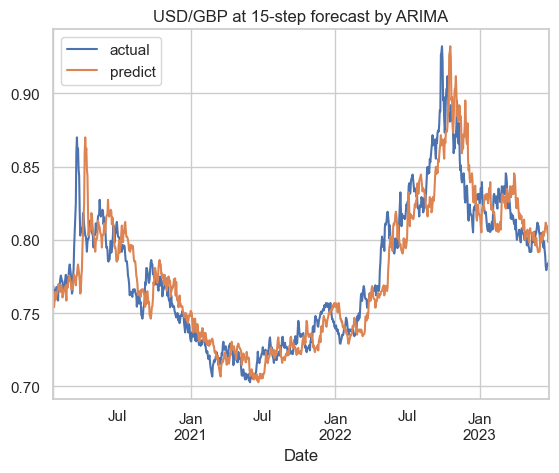

Mean Error: 0.0005
Root Mean Squared Error: 0.0189
Mean Absolute Percentage Error: 1.7583


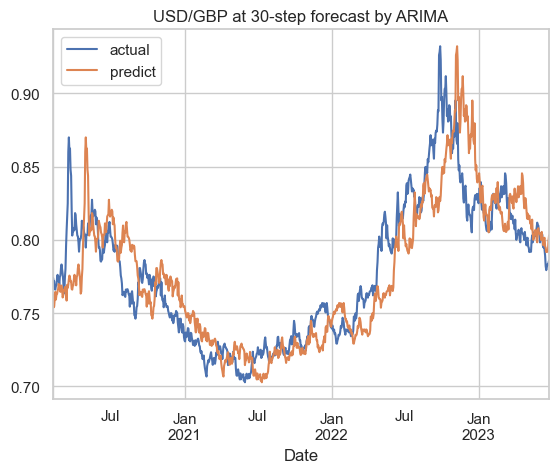

Mean Error: 0.0011
Root Mean Squared Error: 0.0253
Mean Absolute Percentage Error: 2.3928


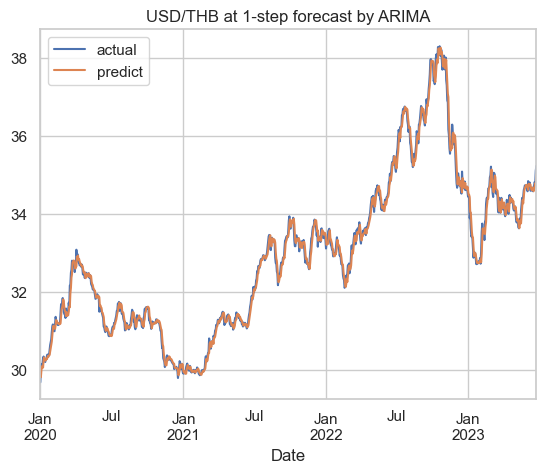

Mean Error: 0.0079
Root Mean Squared Error: 0.1620
Mean Absolute Percentage Error: 0.3642


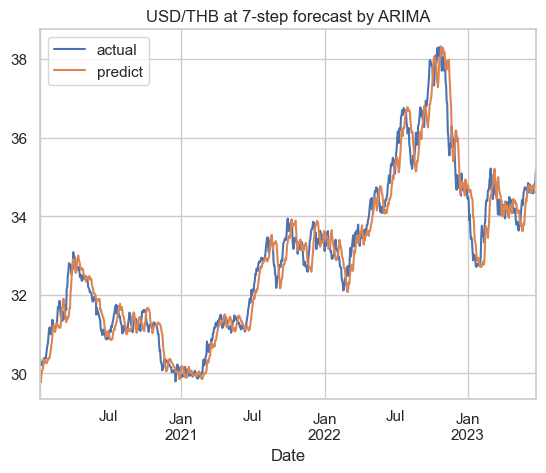

Mean Error: 0.0357
Root Mean Squared Error: 0.4473
Mean Absolute Percentage Error: 1.0222


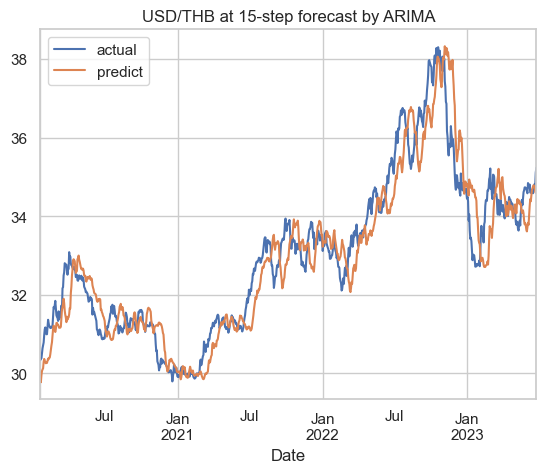

Mean Error: 0.0753
Root Mean Squared Error: 0.7092
Mean Absolute Percentage Error: 1.6431


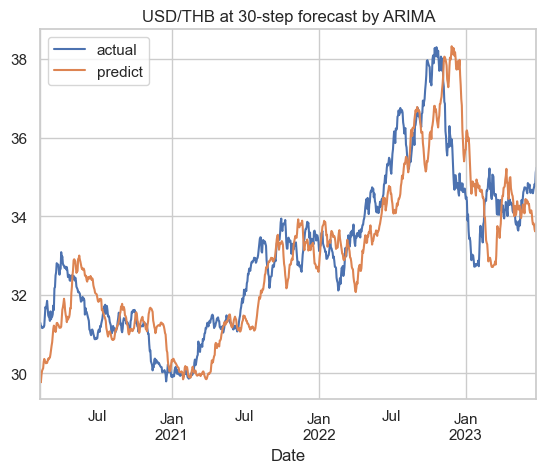

Mean Error: 0.1393
Root Mean Squared Error: 1.0436
Mean Absolute Percentage Error: 2.4136


In [199]:
## import saved predictions
ARIMA_x = pd.read_csv(res_dir + "ARIMA_predictions.csv", index_col = 0)

for cur in currency:
    ARIMA_x[cur] = ARIMA_x[cur].apply(ast.literal_eval)
    
ARIMA_y = ARIMA_x.to_dict()
 
## == AR evaluation == ##
ARIMA_eva = model_evaluation(ARIMA_y, ARIMA_test, model = 'ARIMA')


### LSTM model

#### 4-3-1. Data set
- Define the train and test data

In [200]:
### === LSTM Modelling === ###
## == Input Data == ##
LSTM_train = log_train_set.copy()
LSTM_test = log_test_set.copy()


##### 4-3-2. Hyper parameters tuning
- Grid search
- Adam optimizer
- Vary units, n_layers and dropout rate

In [203]:
# Function to create an LSTM model

def create_lstm_model(units = 20, n_layers = 1 , dropout_rate = 0):
    
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # First layer with input shape
            model.add(LSTM(units = units, activation = 'relu', dropout = dropout_rate, return_sequences = True, batch_input_shape = (1, X_train.shape[1], X_train.shape[2])))
        elif i == n_layers - 1:
            # Last layer without return sequences
            model.add(LSTM(units = units, activation = 'relu', dropout = dropout_rate))
        else:
            # Middle layers with return sequences
            model.add(LSTM(units = units, activation = 'relu', dropout = dropout_rate, return_sequences = True))
                      
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
                      
    return model

LSTM_par = {}
best_par = {}
start = datetime.now()
test_start = datetime.now()

for i, cur in enumerate(currency):
    all_hor = {}
    best_hor = {}
    
    for n_step in n_step_pred:
        all_year = {}
        best_year = {}

        for k in range(len(LSTM_test[0]) - n_step + 1):
            data = pd.concat([LSTM_train[0], LSTM_test[0].iloc[:0 + k]])

            if data.index[-1].year != data.index[-2].year:
                sc = MinMaxScaler()
                sc_data = sc.fit_transform(data)
                in_len = 1
                out_len = 1
                X_train, y_train = [], []

                for i in range(len(sc_data) - in_len - out_len + 1):
                    X_train.append(sc_data[i : i + in_len])
                    y_train.append(sc_data[i + out_len : i + in_len + out_len])

                X_train = np.array(X_train)
                y_train = np.array(y_train)
                y_train = y_train.reshape(y_train.shape[0], -1)

                lstm_model = KerasRegressor(model = create_lstm_model, verbose = 0, epochs = 25, shuffle = False, batch_size = 1, units = 20,  n_layers = 1, dropout_rate = 0)

                param_grid = {'units': [10, 15 ,20], 'n_layers': [1, 2], 'dropout_rate' : [0, 0.1]}

                tscv = TimeSeriesSplit(n_splits = 35)
                grid_search = GridSearchCV(estimator = lstm_model, param_grid = param_grid, n_jobs = -1, cv = tscv, scoring = 'neg_mean_squared_error')
                grid_result = grid_search.fit(X_train, y_train)

                means = grid_result.cv_results_['mean_test_score']
                stds = grid_result.cv_results_['std_test_score']
                params = grid_result.cv_results_['params']
                
                all_result = pd.DataFrame({'mean' : means, 'std' : stds, 'parameters' : params})
                best_result = grid_result.best_params_
                y = data.index[-1].year
                all_year[y] = all_result
                best_year[y] = best_result
                
                test_stop = datetime.now()
                print("{0} is done ... (time: {1})".format(y, test_stop - test_start))
                test_start = datetime.now()
                
        all_hor[n_step] = all_year
        best_hor[n_step] = best_year
        
    LSTM_par[cur] = all_hor
    best_par[cur] = best_hor

stop = datetime.now()
print("time: {0})".format(stop - start))

2020 is done ... (time: 0:19:00.174193)
2021 is done ... (time: 0:20:14.386786)
2022 is done ... (time: 0:16:15.427252)
2023 is done ... (time: 0:15:39.808850)
2020 is done ... (time: 0:13:20.806684)
2021 is done ... (time: 0:14:12.427285)
2022 is done ... (time: 0:15:22.385212)
2023 is done ... (time: 0:18:45.668383)
2020 is done ... (time: 0:15:12.665738)
2021 is done ... (time: 0:14:42.256481)
2022 is done ... (time: 0:14:50.177710)
2023 is done ... (time: 0:14:27.220407)
2020 is done ... (time: 0:12:06.402011)
2021 is done ... (time: 0:13:53.583308)
2022 is done ... (time: 0:15:26.463948)
2023 is done ... (time: 0:18:48.649468)
2020 is done ... (time: 0:15:56.763343)
2021 is done ... (time: 0:16:21.839524)
2022 is done ... (time: 0:20:47.674839)
2023 is done ... (time: 0:21:55.206169)
2020 is done ... (time: 0:16:27.042990)
2021 is done ... (time: 0:16:57.415770)
2022 is done ... (time: 0:16:17.426203)
2023 is done ... (time: 0:19:25.440473)
2020 is done ... (time: 0:15:02.448153)


- Save and import the hyper parametes from the saved file

In [206]:
LSTM_par_pd = pd.DataFrame(LSTM_par)
best_par_pd = pd.DataFrame(best_par)
LSTM_par_pd.to_csv(res_dir + "LSTM_hyperparameters.csv")
best_par_pd.to_csv(res_dir + "LSTM_best_hyperparameters.csv")

In [207]:
LSTM_pars = pd.read_csv(res_dir + "LSTM_best_hyperparameters.csv", index_col = 0)

for cur in currency:
    LSTM_pars[cur] = LSTM_pars[cur].apply(ast.literal_eval)


##### 5-3-3. Model implementation

In [208]:
## == LSTM model == ##
LSTM_preds = {}
LSTM_start = datetime.now()

for i, cur in enumerate(currency):
    hor = {}
    p_year = {}
    
    for n_step in n_step_pred:
        hor[n_step] = []
        print("=== {0} in {1}-step ===".format(cur, n_step))
        start = datetime.now()
        
        for k in range(len(LSTM_test[i]) - n_step + 1):
            data = pd.concat([LSTM_train[i], LSTM_test[i].iloc[:0 + k]])
            y = data.index[-1].year
            if y == 2019:
                y += 1
            dropout_rate, n_layers, units = LSTM_pars[cur][n_step][y].values()

            # Normalize the data
            sc = MinMaxScaler()
            sc_data = sc.fit_transform(data)
            # sc_test = sc.transform(LSTM_test[0])

            # Create the input sequences and corresponding labels for the LSTM model
            in_len = 1
            out_len = n_step
            X_train, y_train = [], []

            for i in range(len(sc_data) - in_len - out_len + 1):
                X_train.append(sc_data[i : i + in_len])
                y_train.append(sc_data[i + out_len : i + in_len + out_len])

            X_train = np.array(X_train)
            y_train = np.array(y_train)
            X_test = sc_data[-1].reshape(1, 1, 1)
            X_test = np.array(X_test)

            # Build the LSTM model
            model = Sequential()
            for i in range(n_layers):
                if i == 0:
                    # First layer with input shape
                    model.add(LSTM(units = units, activation = 'relu', dropout = dropout_rate, return_sequences = True, batch_input_shape = (1, X_train.shape[1], X_train.shape[2])))
                elif i == n_layers - 1:
                    # Last layer without return sequences
                    model.add(LSTM(units = units, activation = 'relu', dropout = dropout_rate))
                else:
                    # Middle layers with return sequences
                    model.add(LSTM(units = units, activation = 'relu', dropout = dropout_rate, return_sequences = True))
            model.add(Dense(units = 1))

            # Compile the model with appropriate loss functions and optimizers
            model.compile(optimizer = 'adam', loss = 'mean_squared_error')

            # Train the model with GPU acceleration
            with tf.device('/GPU:0'):
                early_stop = EarlyStopping(monitor = 'loss', patience = 5, verbose = 0)
                model.fit(X_train , y_train, epochs = 30, batch_size = 1, verbose = 0, shuffle = False, callbacks=[early_stop])

            # Make predictions with GPU acceleration
            with tf.device('/GPU:0'):
                predictions = model.predict(X_test, verbose = 0)

            # Inverse transform the predictions to obtain the original scale
            predictions = predictions.reshape(-1, predictions.shape[-1])
            hor[n_step].append(sc.inverse_transform(predictions))

            if data.index[-1].year != data.index[-2].year:
                stop = datetime.now()
                y = data.index[-1].year
                print("{0} is done ... (time: {1})".format(y - 1, stop - start))
                start = datetime.now()

        y = data.index[-1].year
        stop = datetime.now()
        print("{0} is done ... (time: {1})".format(y, stop - start))
        
    LSTM_preds[cur] = hor

LSTM_stop = datetime.now()
print("LSTM model time: {0}".format(LSTM_stop - LSTM_start))

## Save LSTM_predictions
LSTM_pd = pd.DataFrame(LSTM_preds)
LSTM_pd.to_csv(res_dir + "LSTM_predictions.csv")


=== USD/EUR in 1-step ===
2019 is done ... (time: 0:01:43.631174)
2020 is done ... (time: 4:26:16.618952)
2021 is done ... (time: 4:32:39.963173)


KeyboardInterrupt: 

- Import the prediction from the saved file

In [209]:
## import saved predictions
LSTM_x = pd.read_csv(res_dir + "LSTM_predictions.csv", index_col = 0)

for cur in currency:
    LSTM_x[cur] = LSTM_x[cur].apply(ast.literal_eval)
    
LSTM_y = LSTM_x.to_dict()

##### 5-3-4. Evaluation

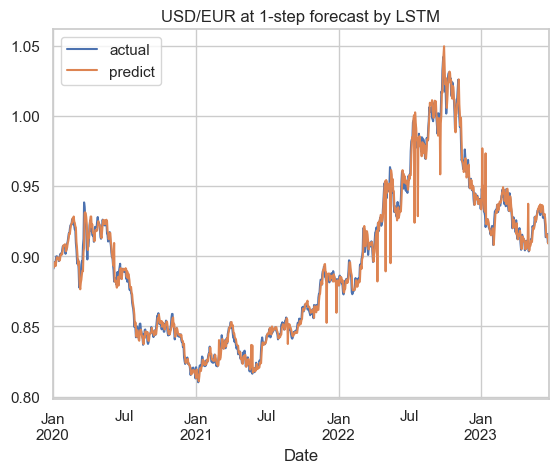

Mean Error: 0.0002
Root Mean Squared Error: 0.0074
Mean Absolute Percentage Error: 0.4658


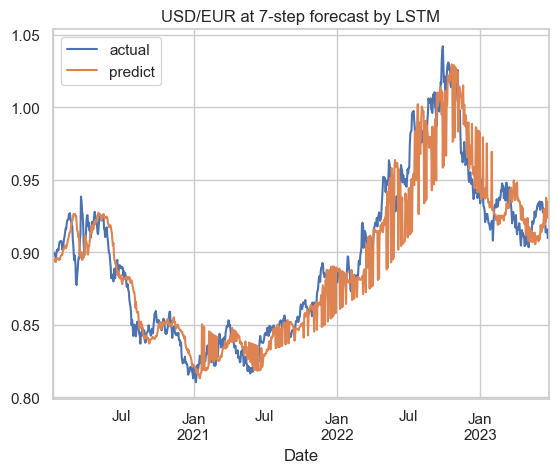

Mean Error: 0.0022
Root Mean Squared Error: 0.0181
Mean Absolute Percentage Error: 1.4778


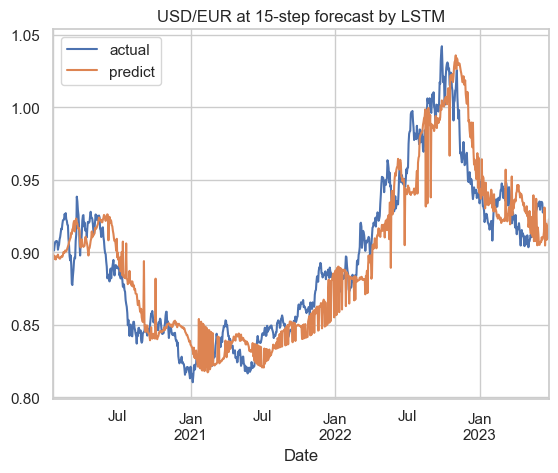

Mean Error: 0.0007
Root Mean Squared Error: 0.0204
Mean Absolute Percentage Error: 1.8160


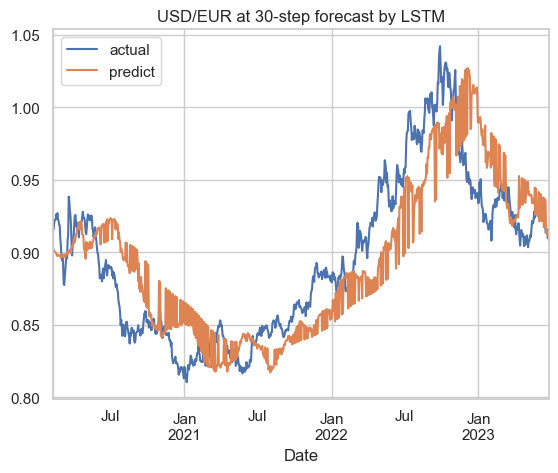

Mean Error: 0.0007
Root Mean Squared Error: 0.0310
Mean Absolute Percentage Error: 2.8006


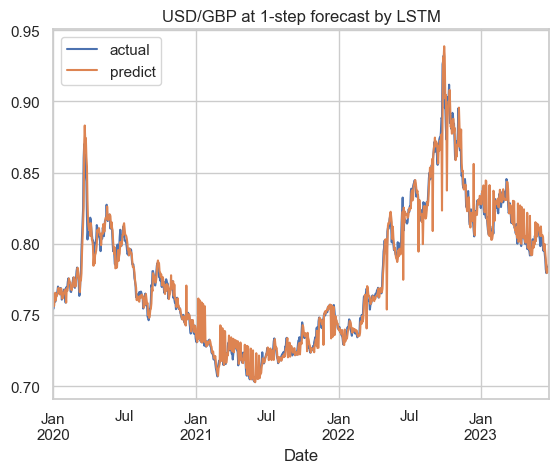

Mean Error: -0.0004
Root Mean Squared Error: 0.0085
Mean Absolute Percentage Error: 0.6685


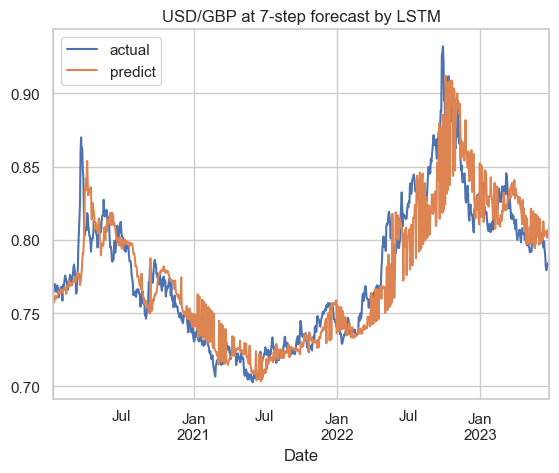

Mean Error: 0.0007
Root Mean Squared Error: 0.0196
Mean Absolute Percentage Error: 1.7675


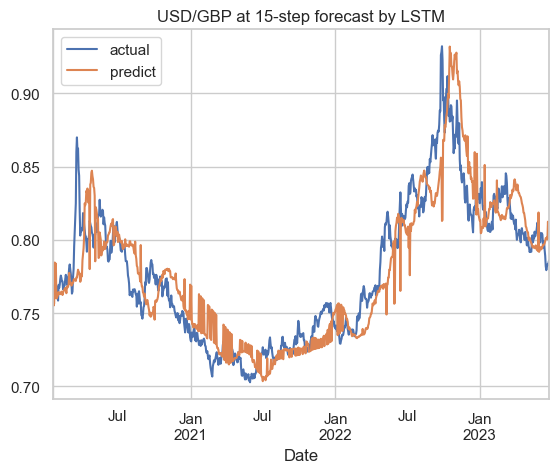

Mean Error: 0.0001
Root Mean Squared Error: 0.0219
Mean Absolute Percentage Error: 2.0936


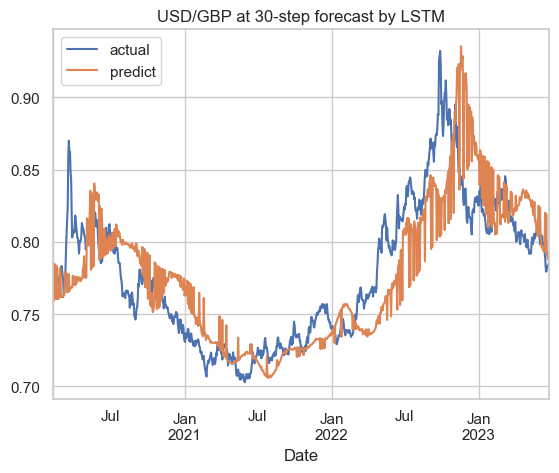

Mean Error: 0.0010
Root Mean Squared Error: 0.0293
Mean Absolute Percentage Error: 2.8271


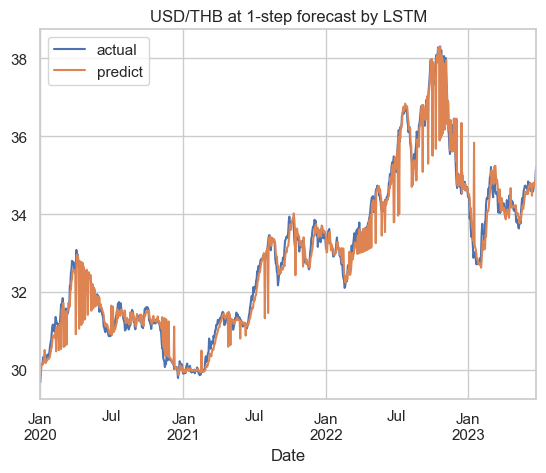

Mean Error: 0.0669
Root Mean Squared Error: 0.4022
Mean Absolute Percentage Error: 0.6995


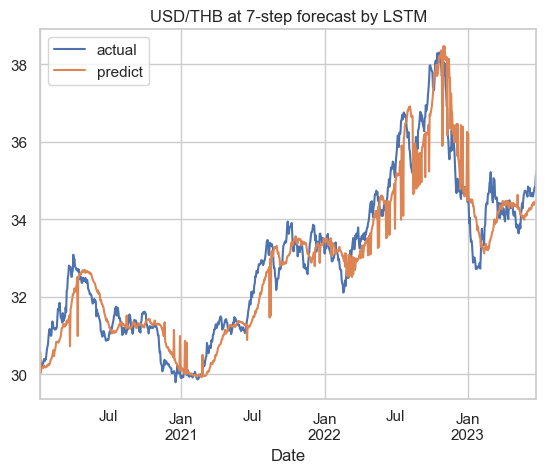

Mean Error: 0.0982
Root Mean Squared Error: 0.6346
Mean Absolute Percentage Error: 1.4557


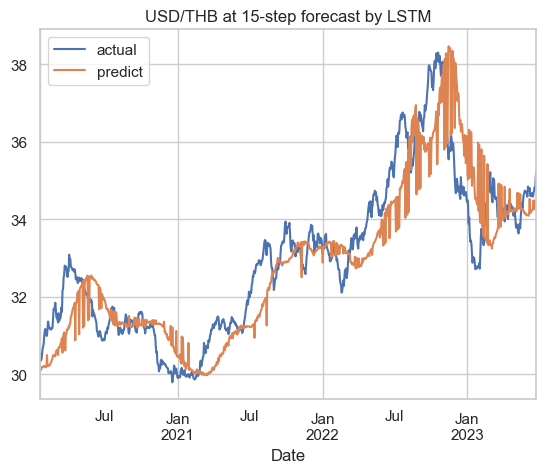

Mean Error: 0.1726
Root Mean Squared Error: 0.9706
Mean Absolute Percentage Error: 2.2423


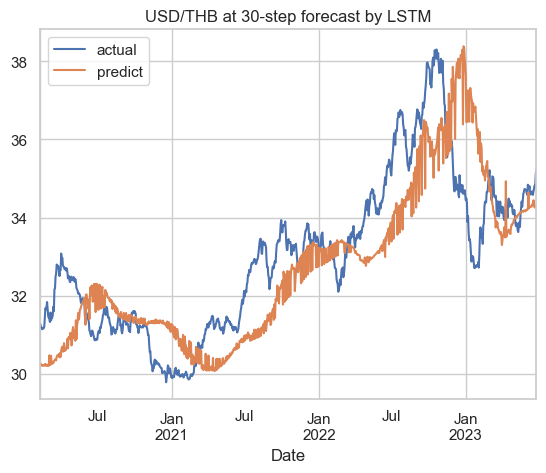

Mean Error: 0.3058
Root Mean Squared Error: 1.3390
Mean Absolute Percentage Error: 3.1580


In [210]:
## == LSTM evaluation == ##
LSTM_eva = model_evaluation(LSTM_y, LSTM_test, model = 'LSTM')